In [1]:
# import necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn

2024-10-27 12:08:42.253148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 12:08:42.253271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 12:08:42.538754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load and create datasets

In [2]:
from keras.datasets.cifar100 import load_data
(X_train, y_train), (X_test, y_test) = load_data()
X_train, X_valid, X_finetune = X_train[10_000:], X_train[:5000], X_train[5000:10_000]
y_train, y_valid, y_finetune = y_train[10_000:], y_train[:5000], y_train[5000:10_000]

print(f"""X_train: {X_train.shape}, y_train: {y_train.shape},
X_valid: {X_valid.shape}, y_valid: {y_valid.shape},
X_finetune: {X_finetune.shape}, y_finetune: {y_finetune.shape},
X_test: {X_test.shape}, y_test: {y_test.shape} """)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_train: (40000, 32, 32, 3), y_train: (40000, 1),
X_valid: (5000, 32, 32, 3), y_valid: (5000, 1),
X_finetune: (5000, 32, 32, 3), y_finetune: (5000, 1),
X_test: (10000, 32, 32, 3), y_test: (10000, 1) 


## Save datasets

In [3]:
with open(f'finetune_imgs.npy', 'wb') as f:
  np.save(f, X_finetune)
with open(f'finetune_lbls.npy', 'wb') as f:
  np.save(f, y_finetune)
with open(f'test_imgs.npy', 'wb') as f:
  np.save(f, X_test)
with open(f'test_lbls.npy', 'wb') as f:
  np.save(f, y_test)
with open(f'valid_imgs.npy', 'wb') as f:
  np.save(f, X_valid)
with open(f'valid_lbls.npy', 'wb') as f:
  np.save(f, y_valid)

## Data augmentations

In [4]:
import numpy as np
from scipy.ndimage import shift, rotate, zoom, gaussian_filter

def shift_image(image, low=-7, high=7):
    """
    Shifts an RGB image along x and y axes based on two random shift values.
    """
    dy = np.random.randint(low, high)
    while dy == 0:
        dy = np.random.randint(low, high)
    dx = np.random.randint(low, high)
    while dx == 0:
        dx = np.random.randint(low, high)
    # Apply shift on all 3 channels
    return np.stack([shift(image[:, :, i], [dy, dx]) for i in range(3)], axis=-1)

def rotate_image(image, low=-45, high=45):
    """
    Rotates and returns an RGB image.
    """
    angle = np.random.randint(low, high)
    while -5 <= angle <= 5:
        angle = np.random.randint(low, high)
    # Apply rotation on all 3 channels
    return np.stack([rotate(image[:, :, i], angle, reshape=False) for i in range(3)], axis=-1)

def zoom_in_out(image, ratio=(1.2, 0.7)):
    """
    Randomly zooms in or out an RGB image and then returns it.
    """
    random_choice = np.random.randint(0, 2)
    if random_choice == 0:
        zoomed_image = np.stack([zoom(image[:, :, i], ratio[0]) for i in range(3)], axis=-1)
        crop_x = (zoomed_image.shape[0] - 32) // 2
        crop_y = (zoomed_image.shape[1] - 32) // 2
        zoomed_image = zoomed_image[crop_x:crop_x + 32, crop_y:crop_y + 32, :]
    else:
        zoomed_image = np.stack([zoom(image[:, :, i], ratio[1]) for i in range(3)], axis=-1)
        pad_x = (32 - zoomed_image.shape[0]) // 2
        pad_y = (32 - zoomed_image.shape[1]) // 2
        zoomed_image = np.pad(zoomed_image, ((pad_x, 32 - zoomed_image.shape[0] - pad_x),
                                             (pad_y, 32 - zoomed_image.shape[1] - pad_y),
                                             (0, 0)), mode='constant')
    return zoomed_image

def blur(image, sigma=1):
    """
    Blurs a given RGB image.
    """
    return np.stack([gaussian_filter(image[:, :, i], sigma) for i in range(3)], axis=-1)

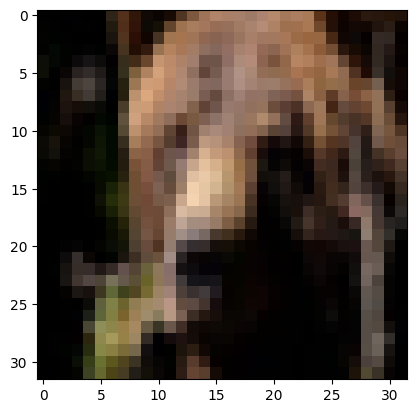

In [5]:
plt.imshow(X_train[100])

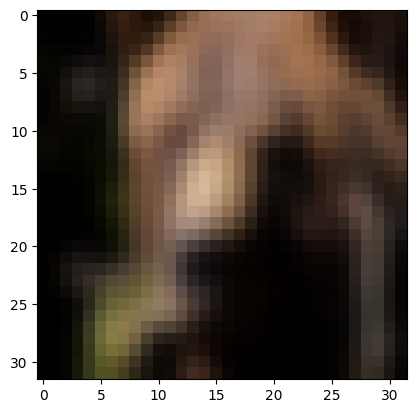

In [6]:
plt.imshow(blur(X_train[100]))

In [7]:
def augment_dataset(original_dataset):
  """Randomly selects one augmentation technique and applies this to the image
  """
  np.random.shuffle(original_dataset)
  augmented_dataset = original_dataset.copy()
  num_of_augmentations = 4
  aug_functions = [
      shift_image, rotate_image, zoom_in_out, blur
  ]
  for i in range(augmented_dataset.shape[0]):
    chosen_aug = random.choice(aug_functions)
    augmented_dataset[i] = chosen_aug(augmented_dataset[i])

  dataset = np.concatenate((original_dataset.reshape((-1, 1, 3*32*32)), augmented_dataset.reshape((-1, 1, 3*32*32))), axis=1)

  return dataset

## Build the model

In [8]:
def create_model():
    inputs = keras.layers.Input(shape=(3*32*32,))
    layer1 = keras.layers.Dense(1000, activation='selu',
                                kernel_initializer = 'glorot_uniform' , kernel_regularizer = tf.keras.regularizers.L2(0.1))(inputs)
    layer2 = keras.layers.Dense(800, activation='selu',
                                kernel_initializer = 'glorot_uniform', kernel_regularizer = tf.keras.regularizers.L2(0.1))(layer1)
    layer3 = keras.layers.Dense(600, activation='selu',
                                kernel_initializer = 'glorot_uniform', kernel_regularizer = tf.keras.regularizers.L2(0.1))(layer2)
    layer4 = keras.layers.Dense(400, activation='selu',
                                kernel_initializer = 'glorot_uniform', kernel_regularizer = tf.keras.regularizers.L2(0.1))(layer3)
    model = keras.models.Model(inputs=inputs, outputs=[layer1, layer2, layer3, layer4])
    return model

model = create_model()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     3,073,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 800)            │       800,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 600)            │       480,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 400)            │       240,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,594,800 (17.53 MB)

 Trainable params: 4,594,800 (17.53 MB)

 Non-trainable params: 0 (0.00 B)

## VICReg loss

In [9]:
def vicreg_loss(z_a, z_b, var_weight = 25, inv_weight = 25, cov_weight = 1):
  # variance loss
  variance_loss_epsilon = 1e-5
  std_z_a = tf.sqrt(tf.math.reduce_variance(z_a, axis=0) + variance_loss_epsilon)
  std_z_b = tf.sqrt(tf.math.reduce_variance(z_b, axis=0) + variance_loss_epsilon)
  loss_v_a = tf.reduce_mean(tf.nn.relu(1 - std_z_a))
  loss_v_b = tf.reduce_mean(tf.nn.relu(1 - std_z_b))
  loss_var = loss_v_a + loss_v_b

  # invariance loss
  loss_inv = tf.reduce_mean(tf.reduce_sum(tf.square(z_a - z_b), axis = 1))

  #covariance loss
  N, D = z_a.shape
  z_a = z_a - tf.reduce_mean(z_a, axis=0)
  z_b = z_b - tf.reduce_mean(z_b, axis=0)
  cov_z_a = tf.square(tf.matmul(tf.transpose(z_a), z_a) / (N - 1))
  cov_z_b = tf.square(tf.matmul(tf.transpose(z_b), z_b) / (N - 1))
  loss_c_a = (tf.reduce_sum(cov_z_a)- tf.reduce_sum(tf.linalg.diag_part(cov_z_a))) / D
  loss_c_b = (tf.reduce_sum(cov_z_b)- tf.reduce_sum(tf.linalg.diag_part(cov_z_b))) / D
  loss_cov = loss_c_a + loss_c_b

  #total weighted loss
  total_loss = (var_weight * loss_var) + (inv_weight * loss_inv) + (cov_weight * loss_cov)
  return total_loss

In [10]:
layer1 = model.layers[1]
layer2 = model.layers[2]
layer3 = model.layers[3]
layer4 = model.layers[4]

layers = [layer1, layer2, layer3, layer4]

learning_rate_layer1 = 0.000001
learning_rate_layer2 = 0.000001
learning_rate_layer3 = 0.000001
learning_rate_layer4 = 0.000001

optimizer_layer1 = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer1)
optimizer_layer2 = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer2)
optimizer_layer3 = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer3)
optimizer_layer4 = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer4)

optimizers = [optimizer_layer1, optimizer_layer2, optimizer_layer3, optimizer_layer4]

var_weights = [25, 25, 25, 25]
inv_weights = [25, 25, 25, 25]
cov_weights = [1, 1, 1, 1]

## Visualization

In [11]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
def plot_figure(model, epoch, plot_list):
  tsne = TSNE()
  data_2D = tsne.fit_transform(model(X_test.reshape((-1, 3*32*32)))[2])
  data_viz = np.concatenate((data_2D, y_test.reshape(len(y_test), 1)), axis = 1)
  data_viz = pd.DataFrame(data_viz, columns = ["dim1", "dim2", "y"])
  plt.figure(figsize = (15, 10))
  sns.scatterplot(data = data_viz, x = "dim1", y = "dim2", hue = "y", palette = "deep")
  plt.title(f"Epoch:{epoch+1}",fontsize=16, fontweight='bold')
  plt.xlabel('Dimension 1', fontsize=14, weight = 'bold')
  plt.ylabel('Dimension 2', fontsize=14, weight = 'bold')
  plt.savefig(f"plot{epoch}.png")
  plot_list.append(f"plot{epoch}.png")
  plt.show()

## Training loop

In [12]:
epochs = 50
plot_list = []
losses1, losses2, losses3, losses4 = [], [], [], []
losses = [losses1, losses2, losses3, losses4]
dv_index1, dv_index2, dv_index3, dv_index4 = [], [], [], []

for epoch in range(epochs):
  dataset = augment_dataset(X_train)
  dataset = dataset.astype('float32') / 255
  dataset = tf.data.Dataset.from_tensor_slices((dataset))

  BATCH_SIZE = 1024
  SHUFFLE_BUFFER_SIZE = 25000
  dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

  iteration1, iteration2, iteration3, iteration4 = 0, 0, 0, 0
  loss1, loss2,loss3, loss4 = 0., 0., 0., 0.
  for batch in dataset:
    x = batch[:, 0, :]
    y = batch[:, 1, :]
    for layer, optimizer, var, inv, cov, loss_ in zip(layers, optimizers, var_weights, inv_weights, cov_weights, losses):

      #TRAINING LAYER 1
      if layer == layers[0]:
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss1 += loss
        iteration1 += 1

      #TRAINING LAYER 2
      if layer == layers[1]:
        x = layers[0](batch[:, 0, :])
        y = layers[0](batch[:, 1, :])
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss2 += loss
        iteration2 += 1

      #TRAINING LAYER 3
      if layer == layers[2]:
        x = layers[1](layers[0](batch[:, 0, :]))
        y = layers[1](layers[0](batch[:, 1, :]))
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss3 += loss
        iteration3 += 1

      #TRAINING LAYER 4
      if layer == layers[3]:
        x = layers[2](layers[1](layers[0](batch[:, 0, :])))
        y = layers[2](layers[1](layers[0](batch[:, 1, :])))
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss4 += loss
        iteration4 += 1

  dv_index1.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 3*32*32)))[0], y_valid))
  dv_index2.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 3*32*32)))[1], y_valid))
  dv_index3.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 3*32*32)))[2], y_valid))
  dv_index4.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 3*32*32)))[3], y_valid))

  print(f"""
  Layer 1 DV Index: {dv_index1[-1]},
  Layer 2 DV Index: {dv_index2[-1]},
  Layer 3 DV Index: {dv_index3[-1]},
  Layer 4 DV Index: {dv_index4[-1]}
  """)

  losses1.append(loss1 / 40.)
  losses2.append(loss2 / 40.)
  losses3.append(loss3 / 40.)
  losses4.append(loss4 / 40.)

  #if epoch % 5 == 0:
  #  plot_list.append(plot_figure(model, epoch, plot_list))
  #elif epoch == epochs - 1:
  #  plot_list.append(plot_figure(model, epoch, plot_list))
  print(f'Epoch {epoch} ends here.')

  learning_rate_layer1 = 0.000001*0.1**(epoch/150)
  learning_rate_layer2 = 0.000001*0.1**(epoch/150)
  learning_rate_layer3 = 0.000001*0.1**(epoch/150)
  learning_rate_layer4 = 0.000001*0.1**(epoch/150)
  optimizers[0] = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer1)
  optimizers[1] = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer2)
  optimizers[2] = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer3)
  optimizers[3] = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_layer4)
  print("===========================================================================================================================================")
  dataset = dataset.unbatch()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.202223566288456,
  Layer 2 DV Index: 9.213073575883866,
  Layer 3 DV Index: 9.56938570347136,
  Layer 4 DV Index: 9.700612597342909
  
Epoch 0 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.18790670344754,
  Layer 2 DV Index: 9.195447652464518,
  Layer 3 DV Index: 9.547410212004847,
  Layer 4 DV Index: 9.681840427996333
  
Epoch 1 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.173884899036269,
  Layer 2 DV Index: 9.178393117598779,
  Layer 3 DV Index: 9.526177371835002,
  Layer 4 DV Index: 9.663662121566386
  
Epoch 2 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.16022116777595,
  Layer 2 DV Index: 9.161959928881155,
  Layer 3 DV Index: 9.506173067214274,
  Layer 4 DV Index: 9.646472173119465
  
Epoch 3 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.147169462147012,
  Layer 2 DV Index: 9.14701889547962,
  Layer 3 DV Index: 9.487467527336664,
  Layer 4 DV Index: 9.630744748651505
  
Epoch 4 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.134078628396125,
  Layer 2 DV Index: 9.132950639637151,
  Layer 3 DV Index: 9.469460306736176,
  Layer 4 DV Index: 9.616018075899353
  
Epoch 5 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.121665044425393,
  Layer 2 DV Index: 9.119706139058508,
  Layer 3 DV Index: 9.451695913993994,
  Layer 4 DV Index: 9.601751115465476
  
Epoch 6 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.109432303497178,
  Layer 2 DV Index: 9.106851353298458,
  Layer 3 DV Index: 9.435174597462666,
  Layer 4 DV Index: 9.589383354244225
  
Epoch 7 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.097723774349335,
  Layer 2 DV Index: 9.095471445994555,
  Layer 3 DV Index: 9.420210403681454,
  Layer 4 DV Index: 9.577821249454885
  
Epoch 8 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.086599266971643,
  Layer 2 DV Index: 9.084870872878575,
  Layer 3 DV Index: 9.406047817658683,
  Layer 4 DV Index: 9.566834208618062
  
Epoch 9 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.07640739189073,
  Layer 2 DV Index: 9.075752753975495,
  Layer 3 DV Index: 9.393250975721768,
  Layer 4 DV Index: 9.555994971994553
  
Epoch 10 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.066516121851269,
  Layer 2 DV Index: 9.067049632219506,
  Layer 3 DV Index: 9.381279930716465,
  Layer 4 DV Index: 9.54573107991391
  
Epoch 11 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.056915426102906,
  Layer 2 DV Index: 9.059335563949352,
  Layer 3 DV Index: 9.370869650221964,
  Layer 4 DV Index: 9.53661512635097
  
Epoch 12 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.047694396722052,
  Layer 2 DV Index: 9.052096572889715,
  Layer 3 DV Index: 9.361674267062371,
  Layer 4 DV Index: 9.527542661946649
  
Epoch 13 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.039136505123118,
  Layer 2 DV Index: 9.045448288324478,
  Layer 3 DV Index: 9.353746889688098,
  Layer 4 DV Index: 9.51844475311805
  
Epoch 14 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.031107279726333,
  Layer 2 DV Index: 9.039212459005993,
  Layer 3 DV Index: 9.34759462042772,
  Layer 4 DV Index: 9.510621258903175
  
Epoch 15 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.023462468401272,
  Layer 2 DV Index: 9.033352743337685,
  Layer 3 DV Index: 9.342277885827462,
  Layer 4 DV Index: 9.503279583945027
  
Epoch 16 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.016058578066032,
  Layer 2 DV Index: 9.028032184192169,
  Layer 3 DV Index: 9.337402998556042,
  Layer 4 DV Index: 9.496273694822742
  
Epoch 17 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.009442923161822,
  Layer 2 DV Index: 9.023300018054748,
  Layer 3 DV Index: 9.332863019555377,
  Layer 4 DV Index: 9.489769405740152
  
Epoch 18 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 9.00302155646166,
  Layer 2 DV Index: 9.018863234280179,
  Layer 3 DV Index: 9.328116826450868,
  Layer 4 DV Index: 9.48455309475272
  
Epoch 19 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.997139687048753,
  Layer 2 DV Index: 9.015121793787335,
  Layer 3 DV Index: 9.324024145278148,
  Layer 4 DV Index: 9.480102622379954
  
Epoch 20 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.991639677637865,
  Layer 2 DV Index: 9.012166533050609,
  Layer 3 DV Index: 9.320335118908579,
  Layer 4 DV Index: 9.47626891897585
  
Epoch 21 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.986139666399753,
  Layer 2 DV Index: 9.009439280205303,
  Layer 3 DV Index: 9.317333880340351,
  Layer 4 DV Index: 9.47324087337235
  
Epoch 22 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.981392615244523,
  Layer 2 DV Index: 9.007514272942979,
  Layer 3 DV Index: 9.315474590293958,
  Layer 4 DV Index: 9.471811197070625
  
Epoch 23 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.976813286452261,
  Layer 2 DV Index: 9.00581868498691,
  Layer 3 DV Index: 9.313901724097603,
  Layer 4 DV Index: 9.470724143306485
  
Epoch 24 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.97236268230758,
  Layer 2 DV Index: 9.004655770236742,
  Layer 3 DV Index: 9.312765223819863,
  Layer 4 DV Index: 9.470666401812975
  
Epoch 25 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.968264852532698,
  Layer 2 DV Index: 9.003972451666574,
  Layer 3 DV Index: 9.311832367260015,
  Layer 4 DV Index: 9.471073340038801
  
Epoch 26 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.964305300756983,
  Layer 2 DV Index: 9.003691095836029,
  Layer 3 DV Index: 9.310581299690908,
  Layer 4 DV Index: 9.470612122496243
  
Epoch 27 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.96080840399911,
  Layer 2 DV Index: 9.003934974772223,
  Layer 3 DV Index: 9.310148136539974,
  Layer 4 DV Index: 9.471185716156208
  
Epoch 28 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.957641997293543,
  Layer 2 DV Index: 9.004366014539505,
  Layer 3 DV Index: 9.30931083224668,
  Layer 4 DV Index: 9.471698503590561
  
Epoch 29 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.954405032738196,
  Layer 2 DV Index: 9.004805768591462,
  Layer 3 DV Index: 9.308264391194294,
  Layer 4 DV Index: 9.47188910013616
  
Epoch 30 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.951376831206067,
  Layer 2 DV Index: 9.005595805242786,
  Layer 3 DV Index: 9.308647320397514,
  Layer 4 DV Index: 9.47374075373274
  
Epoch 31 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.948724109359308,
  Layer 2 DV Index: 9.006408687422436,
  Layer 3 DV Index: 9.309140291187108,
  Layer 4 DV Index: 9.47589278908091
  
Epoch 32 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.946341158108478,
  Layer 2 DV Index: 9.00721930346725,
  Layer 3 DV Index: 9.309607185665802,
  Layer 4 DV Index: 9.478638254295753
  
Epoch 33 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.944034048343818,
  Layer 2 DV Index: 9.008077579998716,
  Layer 3 DV Index: 9.310014657989315,
  Layer 4 DV Index: 9.481004118145057
  
Epoch 34 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.941750311753914,
  Layer 2 DV Index: 9.00901090767592,
  Layer 3 DV Index: 9.310896780788317,
  Layer 4 DV Index: 9.483199740117946
  
Epoch 35 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.939793276656388,
  Layer 2 DV Index: 9.010084185915382,
  Layer 3 DV Index: 9.31198740187632,
  Layer 4 DV Index: 9.48584720080228
  
Epoch 36 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.938018045434905,
  Layer 2 DV Index: 9.011102326724348,
  Layer 3 DV Index: 9.312908106466896,
  Layer 4 DV Index: 9.48836301487998
  
Epoch 37 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.93667571340661,
  Layer 2 DV Index: 9.011891986295126,
  Layer 3 DV Index: 9.313736856788282,
  Layer 4 DV Index: 9.49103226729617
  
Epoch 38 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.935628512853597,
  Layer 2 DV Index: 9.012395110500231,
  Layer 3 DV Index: 9.31426237485656,
  Layer 4 DV Index: 9.493033186912148
  
Epoch 39 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.93481894616293,
  Layer 2 DV Index: 9.013085568425911,
  Layer 3 DV Index: 9.315083365903863,
  Layer 4 DV Index: 9.495309668251373
  
Epoch 40 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.93406794959456,
  Layer 2 DV Index: 9.013744855706909,
  Layer 3 DV Index: 9.315834651260257,
  Layer 4 DV Index: 9.497306816082014
  
Epoch 41 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.9335148786758,
  Layer 2 DV Index: 9.01468908233209,
  Layer 3 DV Index: 9.316968970813711,
  Layer 4 DV Index: 9.499415473729718
  
Epoch 42 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.932817503397139,
  Layer 2 DV Index: 9.015581963263411,
  Layer 3 DV Index: 9.318135574443868,
  Layer 4 DV Index: 9.501023740233494
  
Epoch 43 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.932289727435858,
  Layer 2 DV Index: 9.016594768118203,
  Layer 3 DV Index: 9.319722811438846,
  Layer 4 DV Index: 9.502879105700444
  
Epoch 44 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.931783096426766,
  Layer 2 DV Index: 9.017659340597794,
  Layer 3 DV Index: 9.321321584548024,
  Layer 4 DV Index: 9.505087573370934
  
Epoch 45 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.93144702916922,
  Layer 2 DV Index: 9.018723871346007,
  Layer 3 DV Index: 9.32307225989528,
  Layer 4 DV Index: 9.507388259465566
  
Epoch 46 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.931111366653273,
  Layer 2 DV Index: 9.019948657066328,
  Layer 3 DV Index: 9.324626353406053,
  Layer 4 DV Index: 9.509390918149158
  
Epoch 47 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


  Layer 1 DV Index: 8.930827519630663,
  Layer 2 DV Index: 9.021335028868172,
  Layer 3 DV Index: 9.32621640361896,
  Layer 4 DV Index: 9.511365990735332
  
Epoch 48 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



  Layer 1 DV Index: 8.93066370663256,
  Layer 2 DV Index: 9.022877415531651,
  Layer 3 DV Index: 9.327621427135428,
  Layer 4 DV Index: 9.513073481376484
  
Epoch 49 ends here.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Evaluation

In [13]:
print(f"""
LAYER 1: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 3*32*32)))[0], y_test)},
LAYER 2: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 3*32*32)))[1], y_test)},
LAYER 3: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 3*32*32)))[2], y_test)},
LAYER 4: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 3*32*32)))[3], y_test)}
      """)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



LAYER 1: 10.431673461065996,
LAYER 2: 10.596896368428654,
LAYER 3: 10.83754566983391,
LAYER 4: 11.017214092008254
      


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
print(f"""
LAYER 1: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 3*32*32)))[0], y_test)},
LAYER 2: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 3*32*32)))[1], y_test)},
LAYER 3: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 3*32*32)))[2], y_test)},
LAYER 4: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 3*32*32)))[3], y_test)}
      """)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



LAYER 1: 13.644506152277922,
LAYER 2: 13.450984786482296,
LAYER 3: 13.050997232685662,
LAYER 4: 13.045160146059718
      


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
print(f"""
LAYER 1: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 3*32*32)))[0], y_test)},
LAYER 2: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 3*32*32)))[1], y_test)},
LAYER 3: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 3*32*32)))[2], y_test)},
LAYER 4: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 3*32*32)))[3], y_test)}
      """)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


LAYER 1: -0.11377446353435516,
LAYER 2: -0.11416716128587723,
LAYER 3: -0.12041846662759781,
LAYER 4: -0.12234964966773987
      


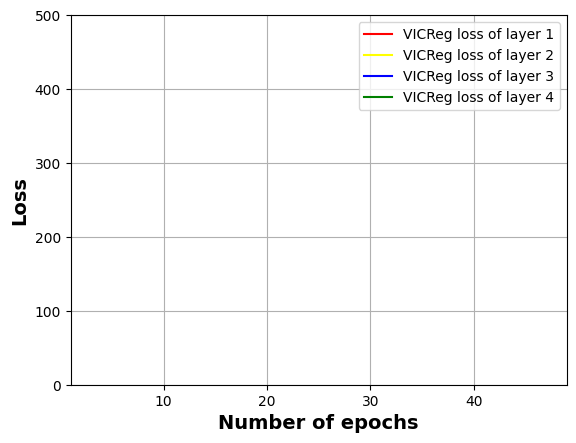

In [16]:
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses1]), label = "VICReg loss of layer 1", color = 'red')
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses2]), label = "VICReg loss of layer 2", color = 'yellow')
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses3]), label = "VICReg loss of layer 3", color = 'blue')
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses4]), label = "VICReg loss of layer 4", color = 'green')
plt.xlabel('Number of epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xlim(1, 49)
plt.ylim(0, 500)
plt.grid(True)
plt.legend()
plt.show()

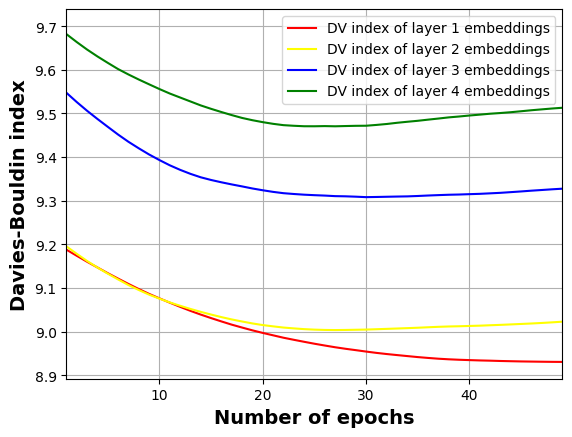

In [17]:
plt.plot(np.arange(0,50), np.array(dv_index1), label = "DV index of layer 1 embeddings", color = 'red')
plt.plot(np.arange(0,50), np.array(dv_index2), label = "DV index of layer 2 embeddings", color = 'yellow')
plt.plot(np.arange(0,50), np.array(dv_index3), label = "DV index of layer 3 embeddings", color = 'blue')
plt.plot(np.arange(0,50), np.array(dv_index4), label = "DV index of layer 4 embeddings", color = 'green')
plt.xlabel('Number of epochs', fontsize=14, fontweight='bold')
plt.ylabel('Davies-Bouldin index', fontsize=14, fontweight='bold')
plt.xlim(1, 49)
#plt.ylim(4.8, 7.5)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
model.save('model.keras')
model.save('model.h5')

In [19]:
dataset = augment_dataset(X_train)
dataset = dataset.astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((dataset))

BATCH_SIZE = 1024
SHUFFLE_BUFFER_SIZE = 25000
dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [20]:
import tensorflow as tf

# Get the number of batches in the dataset
num_batches = tf.data.experimental.cardinality(dataset).numpy()
print(f"Number of batches: {num_batches}")

Number of batches: 40


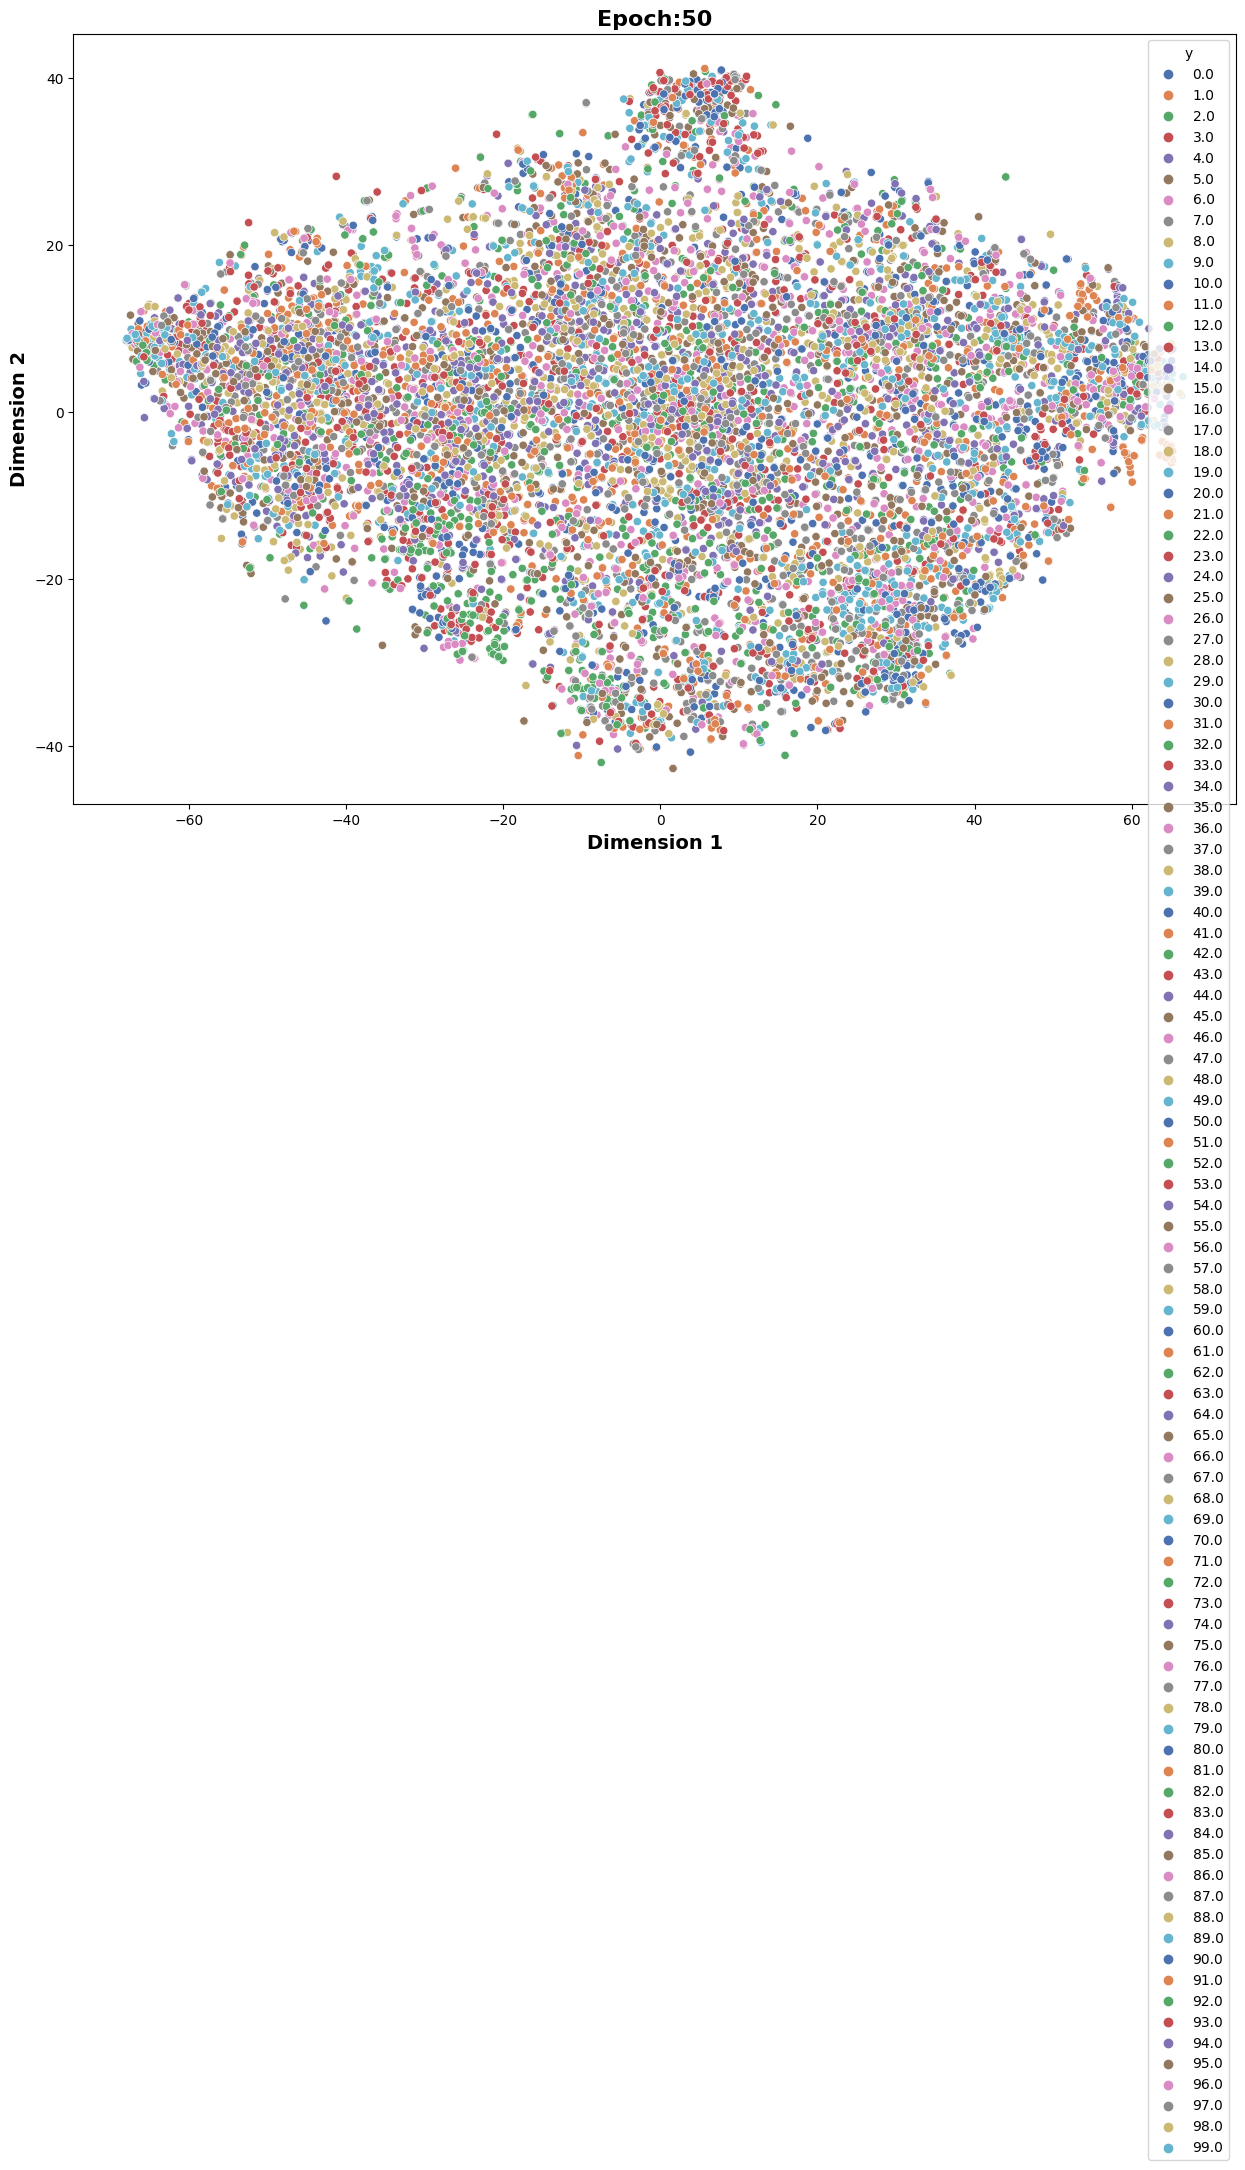

In [21]:
tsne = TSNE()
data_2D = tsne.fit_transform(model(X_test.reshape((-1, 3*32*32)))[2])
data_viz = np.concatenate((data_2D, y_test.reshape(len(y_test), 1)), axis = 1)
data_viz = pd.DataFrame(data_viz, columns = ["dim1", "dim2", "y"])
plt.figure(figsize = (15, 10))
sns.scatterplot(data = data_viz, x = "dim1", y = "dim2", hue = "y", palette = "deep")
plt.title(f"Epoch:{epoch+1}",fontsize=16, fontweight='bold')
plt.xlabel('Dimension 1', fontsize=14, weight = 'bold')
plt.ylabel('Dimension 2', fontsize=14, weight = 'bold')
plt.savefig(f"plot{epoch}.png")
plot_list.append(f"plot{epoch}.png")
plt.show()